In [1]:
#%%
# Use GPU if CUDA is available
import os
import sys
import torch
import torch.nn as nn
#!pip install PIL
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from helper import *                  #importing helper.py
from help import *
#from util import nextplot   
from PIL import Image 
from matplotlib.pyplot import imshow
torch.cuda.is_available()  
print(torch.__version__)
print('cuda index:', torch.cuda.current_device())
print('gpu num:', torch.cuda.device_count())
print('graphic name:', torch.cuda.get_device_name())
cuda = torch.device('cuda')
print(cuda)  #  11.4

#DEVICE = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu" 
import random

# Set random seed for reproducibility
manualSeed = 2020
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

1.7.0+cu110
cuda index: 0
gpu num: 2
graphic name: NVIDIA GeForce RTX 3090
cuda
Random Seed:  2020


In [2]:
import argparse

parser = argparse.ArgumentParser(description="Regression Tasks such as inpainting, denoising, and super_resolution",
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--ckpt_dir", default="./checkpoint", type=str, dest="ckpt_dir")
parser.add_argument("--log_dir", default="./log", type=str, dest="log_dir")
args, unknown = parser.parse_known_args()

ckpt_dir = args.ckpt_dir
log_dir = args.log_dir

ckpt_dir = '/home/team1/GANs/Teamproject/10_labels/checkpoint'
path = '/home/team1/GANs/Teamproject/10_labels/fake'

from tensorboardX import SummaryWriter
log_dir = '/home/team1/GANs/Teamproject/10_labels/logs'
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))

In [ ]:
!pip install tensorboardX

# 1. 10 Labels

In [3]:
# define an object of the custom dataset for the train folder
data_dir=  '/home/team1/GANs/Conditional_StyleGAN_Logo/'
#label_dir = "C:/Users/ChangGun Choi/Team Project/TeamProject/SVG_Logo/Model/Label/LLD_majorityVote.csv"
#label_dir = "C:/Users/ChangGun Choi/Team Project/TeamProject/SVG_Logo/Model/Label/LLD_weightedMajorityVote.csv"
label_dir = "/home/team1/GANs/Logo/Label/LLD_weightedMajorityVote.csv"
word2index = {"Serveware":0, "Art":1, "Vehicle":2, 'T-shirt': 3, 'Terrestrial animal':4, 'Plastic':5, 'Coffee cup': 6, 'Musician': 7, 'Underwater':8,  'Machine gun': 9 }


#Logo_dataset = StyleDataset_edit(data_dir,data_transformer, label_dir,word2index)
Logo_dataset = StyleDataset(data_dir,data_transformer, label_dir,word2index)
dataloader = torch.utils.data.DataLoader(Logo_dataset, batch_size=64, shuffle=True, num_workers=8, drop_last=True) ##############
dataloader   # Randomly sample batch, drop_last=True : length of Dataset is not dividable by the batch size without a remainder, which happens to be 1
#%%
 #print(imgs.shape())  # input image     # torch.Size([4, 3, 28, 28]) (batch_size, RGB, pixel, pixel)
 # print(labels)    #tensor([1, 1]) : batch is 2 
print(len(dataloader))

#%%
def weights_init(m):
  classname = m.__class__.__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0,0.02)
  
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)
    

808


In [4]:
params = {'nz':100, 
          'ngf':128, 
          'ndf':128, 
          'img_channel':3, 
          'num_classes': 10              ######################### Change
          }



class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        nz = params['nz'] 
        ngf = params['ngf'] 
        img_channel = params['img_channel'] 
        num_class = params['num_classes']
        self.relu= nn.LeakyReLU(0.2)
        self.dconv1 = nn.ConvTranspose2d(nz,ngf*4, 4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*4)  # (ngf*8)*4*4
        self.dconv1_l = nn.ConvTranspose2d(num_class, ngf*4, 4, stride=1, padding=0, bias=False)
        self.bn1_l = nn.BatchNorm2d(ngf*4)  # (ngf*8)*4*4
        
        self.dconv2 = nn.ConvTranspose2d(ngf*8,ngf*4, 4, stride=2, padding=1, bias=False) #
        self.bn2 = nn.BatchNorm2d(ngf*4) # (ngf*4)*8*8
        self.dconv3 = nn.ConvTranspose2d(ngf*4,ngf*2,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)  # (ngf*2)*16*16
        self.dconv4 = nn.ConvTranspose2d(ngf*2,ngf,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)    # ngf * 32 * 32
        self.dconv5 = nn.ConvTranspose2d(ngf,img_channel,4,stride=2,padding=1,bias=False)
                                          # img_channel * 64 *64
    def forward(self,noise,label):
        x = self.relu(self.bn1(self.dconv1(noise)))
        y = self.relu(self.bn1_l(self.dconv1_l(label)))
        #x = self.bn1(self.dconv1(noise))
        #y = self.bn1_l(self.dconv1_l(label))
       
        x = torch.cat([x,y], 1)                  
        
        x = self.relu(self.bn2(self.dconv2(x)))
        x = self.relu(self.bn3(self.dconv3(x)))
        x = self.relu(self.bn4(self.dconv4(x)))
        x = torch.tanh(self.dconv5(x))
        return x
#%%

image_size = 64
label_dim = 10   ### 3
onehot_dim = torch.LongTensor([i for i in range(label_dim)])

# label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, onehot_dim.view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1) 
onehot
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1     # image_size * image_size -> make 1 


# check
x = torch.randn(image_size,100,1,1, device=device).view(-1, 100, 1, 1).cuda() # batch,100,1,1
label = torch.randint(0,label_dim,(image_size,), device=device)  # 3
label   
label = onehot[label].to(device)
label
model_gen = Generator(params).to(device)
#model_gen = torch.nn.DataParallel(model, device_ids=[0,1]).cuda()  # if you have more GPUs
#model_gen = model_gen.to(f'cuda:0')

out_gen = model_gen(x,label)  # 3*64*64  
print(out_gen.shape)      #torch.Size([64, 3, 64, 64])




#%% Ex1)
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        img_channel = params['img_channel'] # 3
        ndf = params['ndf'] # 128
        num_class = params['num_classes']
        self.relu= nn.LeakyReLU(0.2)

        self.conv1 = nn.Conv2d(img_channel,ndf//2,4,stride=2,padding=1,bias=False)
        self.conv1_l = nn.Conv2d(num_class,ndf//2,4,stride=2,padding=1,bias=False)
        
        self.conv2 = nn.Conv2d(ndf,ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2,ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4,ndf*8,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8,    1,4,stride=1,padding=0,bias=False)  # discriminate 1 or 0

    def forward(self, img, label):                    # input : img_channel * 64 * 64
        x = self.relu(self.conv1(img)) #           ndf * 32 * 32
        y = self.relu(self.conv1_l(label)) 
        x = torch.cat([x,y],1)
        
        x = self.relu(self.bn2(self.conv2(x))) #(ndf*2) * 16 *16
        x = self.relu(self.bn3(self.conv3(x))) #(ndf*4)*8*8
        x = self.relu(self.bn4(self.conv4(x))) #(ndf*8)*4*4
        x = torch.sigmoid(self.conv5(x))              # 1*1*1
        return x.view(-1,1).squeeze(0)  # dimension: 1 -> Probability
                                        # sequeeze() : delete size 1  =>> Discriminator wants one value
#%%



x = torch.randn(image_size,params['img_channel'],64,64,device=device) # num = 16
#x = torch.randn(image_size,100,1,1, device=device).view(-1, 100, 1, 1).cuda() # batch,100,1,1
label = torch.randint(0,label_dim,(image_size,), device=device)  # 3
label = fill[label].to(device)
label
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x, label)
print(out_dis.shape)


torch.Size([64, 3, 64, 64])
torch.Size([64, 1])


In [6]:
torch.cuda.is_available()
# Initialization
generator = Generator(params).to(device)        
discriminator = Discriminator(params).to(device)
generator.apply(weights_init).cuda
discriminator.apply(weights_init).cuda

# Loss Function
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# learning rate
lr = 0.0002 #2e-4

# Optimzation
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))



In [7]:
image_size = 64
label_dim = 10
img_list = []
iters = 0
sample_interval = 100 # Which interval of Batch, want to see the results
#start_time = time.time()
loss_history={'gen':[],
              'dis':[]}

In [8]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
fixed_label = torch.randint(0,label_dim,(64,)).to(device) # random label  0~9                                         
fixed_label = onehot[fixed_label].to(device)
#dis_label = fill[label].to(device)


In [13]:
fixed_label

tensor([[[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]]],


        [[[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],



In [11]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean

In [9]:
def save(ckpt_dir, generator, discriminator, optimizer_G, optimizer_D, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'generator': generator.state_dict(), 'discriminator': discriminator.state_dict(),
                'optimizer_G': optimizer_G.state_dict(), 'optimizer_D': optimizer_D.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

def load(ckpt_dir, generator, discriminator, optimizer_G, optimizer_D):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return netG, netD, optimG, optimD, epoch

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]), map_location=device)

    generator.load_state_dict(dict_model['generator'])
    discriminator.load_state_dict(dict_model['discriminator'])
    optimizer_G.load_state_dict(dict_model['optimizer_G'])
    optimizer_D.load_state_dict(dict_model['optimizer_D'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return generator, discriminator, optimizer_G, optimizer_D, epoch

In [22]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad


In [14]:
n_epochs = 130 # How many epochs
st_epoch = 0

#img_list = []
iters = 0
sample_interval = 100 # Which interval of Batch, want to see the results
#start_time = time.time()

train_continue = "no"
model_save_step = len(dataloader)

# Start Train
if train_continue == "on":
    generator,discriminator, optimizer_G,optimizer_D, st_epoch = load(ckpt_dir=ckpt_dir, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D)
      
for epoch in range(n_epochs):

        for i, (imgs, label) in enumerate(dataloader):
            generator.train()
            discriminator.train()

             # Real image
            real_imgs = imgs.to(device)
            real_labels = label.to(device) #################  
            # Creating Ground_truth Discriminator_label
            real = torch.ones(imgs.size(0), 1).to(device)# real: 1   # imgs.size(0) : Batch Size 
            fake = torch.zeros(imgs.size(0), 1).to(device) # fake: 0

            """ Train generator """
            optimizer_G.zero_grad()
            # Sampling random noise

            noise = torch.randn(imgs.size(0), 100, 1, 1, device=device)
            label = torch.randint(0,label_dim,(imgs.size(0),)).to(device) # random label  0~9                                                                
            gen_label = onehot[label].to(device)
            dis_label = fill[label].to(device)
            
            # Generate fake image
            generated_imgs = generator(noise, gen_label) #######
            # Discriminate fake image
            out_dis = discriminator(generated_imgs, dis_label)

            # Loss calculate
            g_loss = adversarial_loss(out_dis, real) # real : 1 
                                    #[0.6,0.7,....]
            # generator update
            g_loss.backward()
            optimizer_G.step()
            ###########################################################################

            """ Train discriminator """
            optimizer_D.zero_grad()

            # Real image
            real_dis_labels = fill[real_labels].to(device)
            out_dis = discriminator(real_imgs, real_dis_labels)
            real_loss = adversarial_loss(out_dis, real)

            # Fake Image
            out_dis = discriminator(generated_imgs.detach(),dis_label)
            fake_loss = adversarial_loss(out_dis, fake) # not update G() during training D()
            # Detaching fake from the graph is necessary to avoid forward-passing the noise through G when we actually update the generator. 
            # If we do not detach, then, although fake is not needed for gradient update of D, it will still be added to the computational graph
            # and as a consequence of backward pass which clears all the variables in the graph (retain_graph=False by default), fake won't be available when G is updated.
            d_loss = (real_loss + fake_loss) / 2

            # update
            d_loss.backward()
            optimizer_D.step()

            loss_history['gen'].append(g_loss.item())
            loss_history['dis'].append(d_loss.item())


            ##########################################################################


            done = epoch * len(dataloader) + i
            # Sample images
            if (done) % sample_interval == 0:
                fake_images = generator(fixed_noise, fixed_label)

                fake_images = fn_denorm(fake_images, mean=0.5, std=0.5).squeeze().detach().cpu()
                out = fn_tonumpy(fake_images)
                out = np.clip(out, a_min=0, a_max=1)

                
                save_image(fake_images,os.path.join(path, '{}_fake.png'.format(done)))  
                writer_train.add_image('out', out, done, dataformats='NHWC')

        writer_train.add_scalar('loss_G', np.mean(loss_history['gen']), epoch)
        writer_train.add_scalar('loss_D', np.mean(loss_history['dis']), epoch)    

        #if epoch % 1 == 0:
        save(ckpt_dir=ckpt_dir, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D, epoch=epoch)

        #if (i+1) % model_save_step==0:
        #torch.save(generator.state_dict(),
         #          os.path.join(path2models, '{}_G.pth'.format(epoch)))
        #torch.save(discriminator.state_dict(),
         #          os.path.join(path2models, '{}_D.pth'.format(epoch)))           

        # print log each epoch
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")

writer_train.close()

[Epoch 0/130] [D loss: 0.000003] [G loss: 24.346315]
[Epoch 1/130] [D loss: 0.000000] [G loss: 28.995289]
[Epoch 2/130] [D loss: 0.000000] [G loss: 29.600559]


KeyboardInterrupt: 

# 2. 3 Labels

## 2-1) Train generator first

In [43]:
path = '/home/team1/GANs/Teamproject/results/generated_img/1st/'
#path2models = '/home/team1/GANs/Teamproject/results/modelsave/2nd/'
ckpt_dir = '/home/team1/GANs/Teamproject/results/new/New'


# label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
onehot
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1     # image_size * image_size -> make 1 

##############################################################################################################

image_size = 64
label_dim = 3

n_epochs = 100 # How many epochs
st_epoch = 0

img_list = []
iters = 0
sample_interval = 404 # Which interval of Batch, want to see the results
#start_time = time.time()
loss_history={'gen':[],
              'dis':[]}


model_save_step = len(dataloader)
if train_continue == "on":
    generator,discriminator, optimizer_G,optimizer_D, st_epoch = load(ckpt_dir=ckpt_dir, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D)
    
    
    for epoch in range(st_epoch + 1, n_epochs + 1):

        for i, (imgs, label) in enumerate(dataloader):
            generator.train()
            discriminator.train()

            #imgs = cv2.cvtColor(img, cv.CV_GRAY2RGB)  #####
            # Real image
            real_imgs = imgs.to(device)
            real_labels = label.to(device) #################  
            # Creating Ground_truth Discriminator_label
            real = torch.ones(imgs.size(0), 1).to(device)# real: 1   # imgs.size(0) : Batch Size 
            fake = torch.zeros(imgs.size(0), 1).to(device) # fake: 0

            """ Train generator """

            optimizer_G.zero_grad()
            # Sampling random noise

            noise = torch.normal(mean=0, std=1, size=(imgs.shape[0], 100)).view(-1, 100, 1, 1).cuda()  # (input_d , latent_dim)
            noise
            label = torch.randint(0,label_dim,(imgs.size(0),)).to(device) # random label  0~9  
            label                                                              # imgs.shape[0] ?????
            gen_label = onehot[label].to(device)
            gen_label
            dis_label = fill[label].to(device)
            # Generate fake image
            generated_imgs = generator(noise, gen_label) #######
            # Discriminate fake image
            out_dis = discriminator(generated_imgs, dis_label)

            # Loss calculate
            g_loss = adversarial_loss(out_dis, real) # real : 1 
                                    #[0.6,0.7,....]
            # generator update
            g_loss.backward()
            optimizer_G.step()
            ###########################################################################

            """ Train discriminator """
            optimizer_D.zero_grad()

            # Real image
            real_dis_labels = fill[real_labels].to(device)
            out_dis = discriminator(real_imgs, real_dis_labels)
            real_loss = adversarial_loss(out_dis, real)

            # Fake Image
            out_dis = discriminator(generated_imgs.detach(),dis_label)
            fake_loss = adversarial_loss(out_dis, fake) # not update G() during training D()
            # Detaching fake from the graph is necessary to avoid forward-passing the noise through G when we actually update the generator. 
            # If we do not detach, then, although fake is not needed for gradient update of D, it will still be added to the computational graph
            # and as a consequence of backward pass which clears all the variables in the graph (retain_graph=False by default), fake won't be available when G is updated.
            d_loss = (real_loss + fake_loss) / 2

            # update
            d_loss.backward()
            optimizer_D.step()

            loss_history['gen'].append(g_loss.item())
            loss_history['dis'].append(d_loss.item())



            done = epoch * len(dataloader) + i
            # Sample images
            if (done) % sample_interval == 0:
                fake_images = generator(fixed_z, fixed_label)

                fake_images = fn_denorm(fake_images, mean=0.5, std=0.5).squeeze().detach().cpu()
                out = fn_tonumpy(fake_images)
                out = np.clip(out, a_min=0, a_max=1)

                #fake_images = fn_denorm(fake_images,mean=0.5,std=0.5).squeeze().detach().cpu()

               
                save_image(fake_images,os.path.join(path, '{}_fake.png'.format(done)))  
                writer_train.add_image('out', out, done, dataformats='NHWC')

        writer_train.add_scalar('loss_G', np.mean(loss_history['gen']), epoch)
        writer_train.add_scalar('loss_D', np.mean(loss_history['dis']), epoch)    

        #if epoch % 1 == 0: 
        save(ckpt_dir=ckpt_dir, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D, epoch=epoch)

        #if (i+1) % model_save_step==0:
        #torch.save(generator.state_dict(),
         #          os.path.join(path2models, '{}_G.pth'.format(epoch)))
        #torch.save(discriminator.state_dict(),
         #          os.path.join(path2models, '{}_D.pth'.format(epoch)))           

        # print log each epoch
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")

    writer_train.close()

[Epoch 42/100] [D loss: 0.012337] [G loss: 3.804037]
[Epoch 43/100] [D loss: 0.017841] [G loss: 7.184323]
[Epoch 44/100] [D loss: 0.243662] [G loss: 0.992825]
[Epoch 45/100] [D loss: 0.017542] [G loss: 4.564490]
[Epoch 46/100] [D loss: 0.062612] [G loss: 2.314266]
[Epoch 47/100] [D loss: 0.072537] [G loss: 3.340902]
[Epoch 48/100] [D loss: 0.228667] [G loss: 1.576295]
[Epoch 49/100] [D loss: 0.005173] [G loss: 5.332358]
[Epoch 50/100] [D loss: 0.069080] [G loss: 5.063301]
[Epoch 51/100] [D loss: 0.006501] [G loss: 7.718324]
[Epoch 52/100] [D loss: 0.003864] [G loss: 6.300745]
[Epoch 53/100] [D loss: 0.074144] [G loss: 6.083169]
[Epoch 54/100] [D loss: 0.049013] [G loss: 3.740442]
[Epoch 55/100] [D loss: 0.033397] [G loss: 3.837892]
[Epoch 56/100] [D loss: 0.007518] [G loss: 9.037756]
[Epoch 57/100] [D loss: 0.020417] [G loss: 12.659281]
[Epoch 58/100] [D loss: 0.019257] [G loss: 6.379631]
[Epoch 59/100] [D loss: 0.000680] [G loss: 10.077316]
[Epoch 60/100] [D loss: 0.024464] [G loss: 4

- tensorboard --logdir=/home/team1/GANs/Teamproject/results/log/train  --host localhost --port 8081

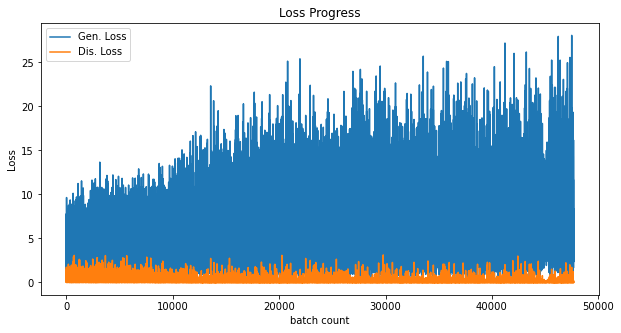

In [44]:
#%%
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2-2) Train discriminator first

- tensorboard --logdir=/home/team1/GANs/Teamproject/results/log/train  --host localhost --port 8081

In [ ]:
path = '/home/team1/GANs/Teamproject/results/generated_img/3/'
#path2models = '/home/team1/GANs/Teamproject/results/modelsave/2nd/'
ckpt_dir = '/home/team1/GANs/Teamproject/results/new/'

image_size = 64
label_dim = 3

# label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2]).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
onehot
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1     # image_size * image_size -> make 1 

n_epochs = 100 # How many epochs
img_list = []
iters = 0
sample_interval = 404 # Which interval of Batch, want to see the results
#start_time = time.time()
loss_history={'gen':[],
              'dis':[]}


model_save_step = len(dataloader)

for epoch in range(n_epochs):
   
    for i, (imgs, label) in enumerate(dataloader):
        generator.train()
        discriminator.train()
        
        #imgs = cv2.cvtColor(img, cv.CV_GRAY2RGB)  #####
        # Real image, label
        real_imgs = imgs.to(device)
        real_labels = label.to(device) #################  
        # Creating Ground_truth Discriminator_label
        real = torch.ones(imgs.size(0), 1).to(device)# real: 1   # imgs.size(0) : Batch Size 
        fake = torch.zeros(imgs.size(0), 1).to(device) # fake: 0
        
        
        # Fake image, label
        noise = torch.randn(imgs.shape[0], 100).view(-1, 100, 1, 1).cuda()  # (input_d , latent_dim)
        label = torch.randint(0,label_dim,(imgs.size(0),)).to(device) # random label  0~9  
        
        # Generate fake image
        gen_label = onehot[label].to(device)
        dis_label = fill[label].to(device)        
        generated_imgs = generator(noise, gen_label) #######
        
         
        """ Train discriminator """
        set_requires_grad(discriminator, True)
        optimizer_D.zero_grad()
        
        # Real image
        real_dis_labels = fill[real_labels].to(device)
        out_dis = discriminator(real_imgs, real_dis_labels)
        real_loss = adversarial_loss(out_dis, real)
        
        # Fake Image
        out_dis = discriminator(generated_imgs.detach(),dis_label)
        fake_loss = adversarial_loss(out_dis, fake) # not update G() during training D()
        # Detaching fake from the graph is necessary to avoid forward-passing the noise through G when we actually update the generator. 
        # If we do not detach, then, although fake is not needed for gradient update of D, it will still be added to the computational graph
        # and as a consequence of backward pass which clears all the variables in the graph (retain_graph=False by default), fake won't be available when G is updated.
        d_loss = (real_loss + fake_loss) / 2

        # update
        d_loss.backward()
        optimizer_D.step()
        
        
        
        """ Train generator """
        set_requires_grad(discriminator, False)
        optimizer_G.zero_grad()
        # Sampling random noise
        
        # Discriminate fake image
        out_dis = discriminator(generated_imgs, dis_label)
        
        # Loss calculate
        g_loss = adversarial_loss(out_dis, real) # real : 1 
                                #[0.6,0.7,....]
        # generator update
        g_loss.backward()
        optimizer_G.step()
        ###########################################################################
       
        
        loss_history['gen'].append(g_loss.item())
        loss_history['dis'].append(d_loss.item())
        
        
        
        done = epoch * len(dataloader) + i
        # Sample images
        if (done) % sample_interval == 0:
            fake_images = generator(fixed_z, fixed_label)
            
            fake_images = fn_denorm(fake_images, mean=0.5, std=0.5).squeeze().detach().cpu()
            out = fn_tonumpy(fake_images)
            out = np.clip(out, a_min=0, a_max=1)
            
            #fake_images = fn_denorm(fake_images,mean=0.5,std=0.5).squeeze().detach().cpu()


            save_image(fake_images,os.path.join(path, '{}_fake.png'.format(done)))  
            writer_train.add_image('out', out, done, dataformats='NHWC')
            
    writer_train.add_scalar('loss_G', np.mean(loss_history['gen']), epoch)
    writer_train.add_scalar('loss_D', np.mean(loss_history['dis']), epoch)    
    
    save(ckpt_dir=ckpt_dir, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D, epoch=epoch)
    
    #if (i+1) % model_save_step==0:
    #torch.save(generator.state_dict(),
     #          os.path.join(path2models, '{}_G.pth'.format(epoch)))
    #torch.save(discriminator.state_dict(),
     #          os.path.join(path2models, '{}_D.pth'.format(epoch)))           
           
    # print log each epoch
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")
    
writer_train.close()

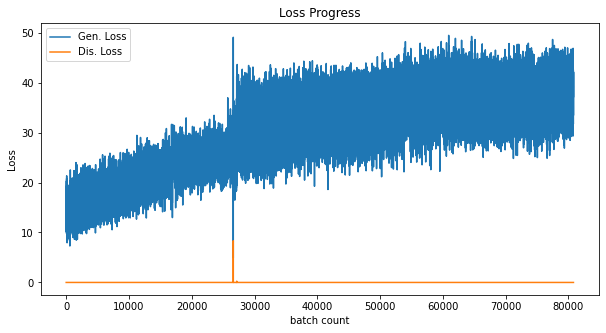

In [113]:
#%%
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

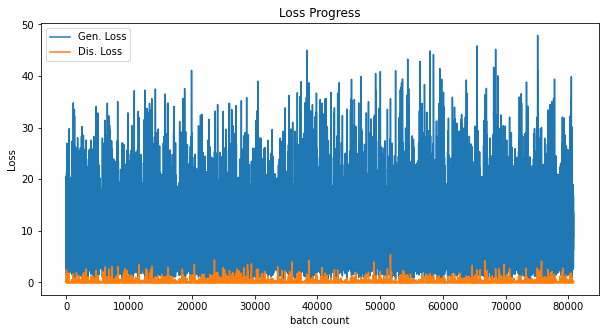

In [82]:
#%%
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

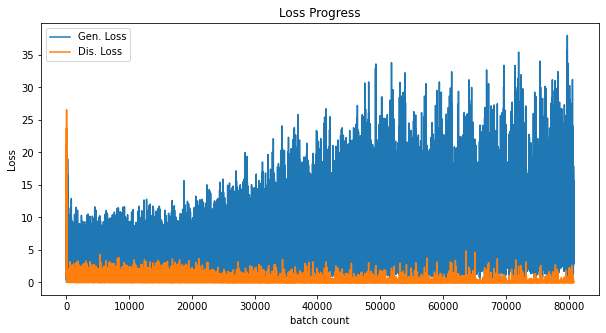

In [47]:
#%%
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
ckpt_dir = '/home/team1/GANs/Teamproject/results/new/'

In [ ]:
generator,discriminator, optimizer_G,optimizer_D, st_epoch = load((ckpt_dir=ckpt_dir, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D)

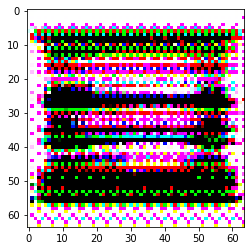

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


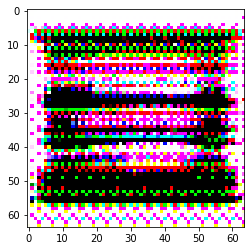

In [33]:
# Load
path2models = '/home/team1/GANs/Teamproject/results/modelsave/1st/'
#path2models = '/home/team1/GANs/Teamproject/results/new/'

Max = 44
#path2weights_gen = os.path.join(path2models, 'model_epoch{}.pth'.format(Max))

#generator,discriminator, optimizer_G,optimizer_D, st_epoch = load(ckpt_dir=path2weights_gen, generator=generator, discriminator = discriminator, optimizer_G=optimizer_G, optimizer_D=optimizer_D)

path2weights_gen = os.path.join(path2models, '{}_G.pth'.format(Max))
path2weights_dis = os.path.join(path2models, '{}_D.pth'.format(Max))

#weights = torch.load(path2weights_gen)
#generator.load_state_dict(weights)


# evalutaion mode
generator.eval()
#%%
# fake image 


import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython import display 
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img)
    plt.show()


def create(inp):  # 7 types of Logo  -> 2 types as a trial
  #feature_map = {"Pictorial":0, "Abstract":1, "lettermarks":2, "Wordmarks":3,"Combination":4, "Mascot":5,"Emblem":6}
  with torch.no_grad():
          feature_map = {"Circle":0, "Font":1, "Triangle":2}
          label_dim = 3
          dim  = 100
          z_noise = torch.randn(64,dim,1,1).view(-1, 100, 1, 1).cuda() # batch,100,1,1
          #one hot encoding
          #label = torch.randint(0,label_dim,(samples,)).to(device) # random label  0~9  

          #gen_label = onehot[label].to(device)
          #Y_label = torch.zeros(16, label_dim).to(device)
          #Y_label[:, feature_map[inp]] = 1
        
          Y_label = torch.full((64, ), feature_map[inp]).to(device)
          Y_label = onehot[Y_label].to(device)
          # run the traineg generator excluding Discriminator
      
          generated_samples = generator(z_noise, Y_label).detach().cpu()
          #print(generated_samples)
          output = generated_samples
          output.shape[0]
          for j in range(output.shape[0]):
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.imshow(np.transpose(output[j],(1,2,0))) 
            
            
create("Circle")
#create("Font")
#create("Triangle")
